# Predicting bank marketing success: building a machine learning classifier on imbalanced data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime 
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve,roc_auc_score, zero_one_loss
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
##create timer func (credit to stackoverflow for this function!)
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [4]:
##data citation

#[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  #In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

In [5]:
## import
file = 'https://raw.githubusercontent.com/SubotaiJC/scriptz/master/bank-full.csv'
data = pd.read_table(file, sep=";")
data = data.sample(frac=1).reset_index(drop=True) #shuffle
data.rename(columns = {'campaign': 'num_of_calls', 'previous': 'prev_contacts'}, inplace=True) #rename some columns to make more sense
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,num_of_calls,pdays,prev_contacts,poutcome,y
0,42,admin.,divorced,secondary,no,-249,yes,no,cellular,14,jul,149,3,-1,0,unknown,no
1,30,blue-collar,single,secondary,no,297,yes,no,cellular,25,jul,218,1,-1,0,unknown,no
2,29,admin.,married,secondary,no,2,yes,no,cellular,6,may,339,1,362,1,failure,no
3,57,blue-collar,married,primary,no,5431,yes,yes,unknown,6,may,383,1,-1,0,unknown,no
4,56,management,married,secondary,no,145,no,no,cellular,4,feb,224,1,-1,0,unknown,no


In [6]:
## data exploration
data.shape #get number of features and rows

(45211, 17)

In [7]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,num_of_calls,pdays,prev_contacts,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


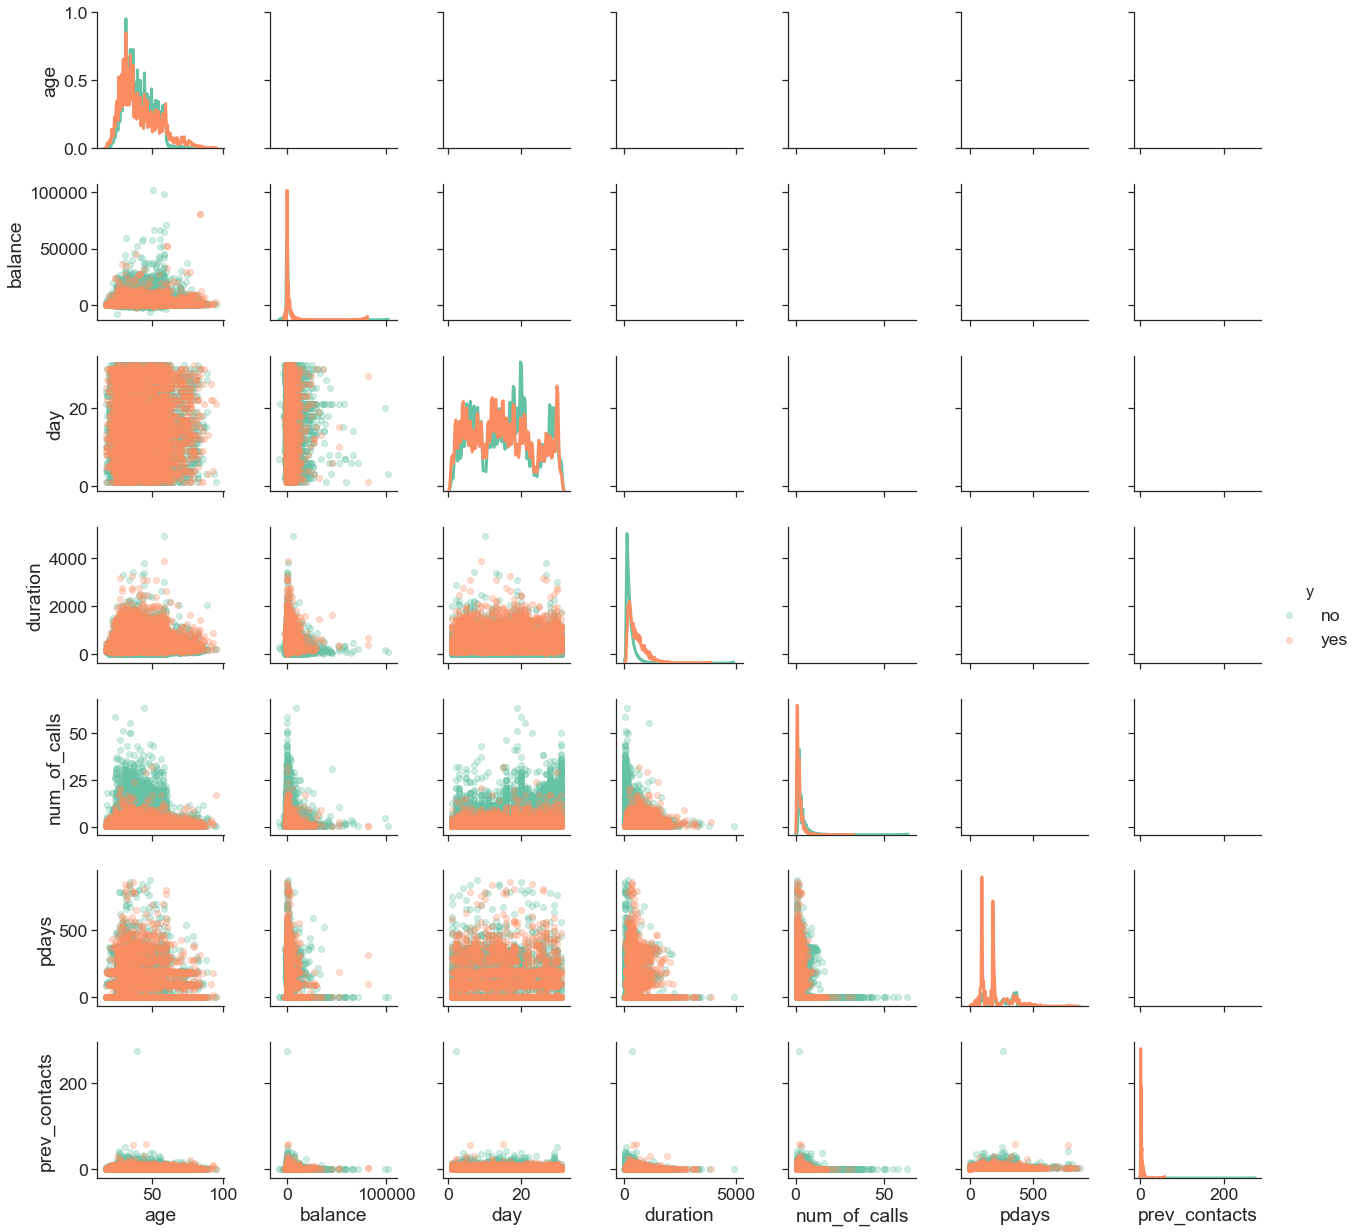

In [8]:
#viz: pairplot
sns.set(font_scale=1.6, style="ticks")
pg = sns.PairGrid(data=data, diag_sharey=False, hue='y', palette='Set2')
pg.map_diag(sns.kdeplot, lw = 3, legend = False, bw=.30)
pg.map_lower(plt.scatter, alpha=0.3)
pg.add_legend()
plt.show()

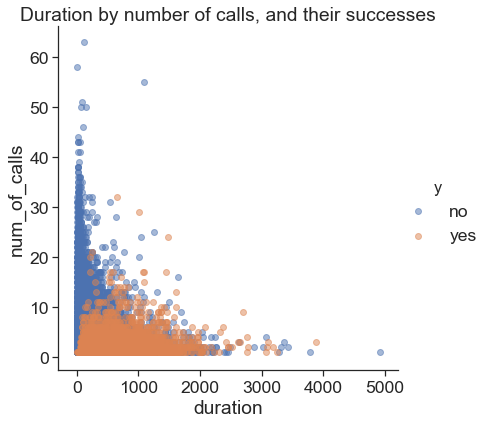

In [9]:
#the relationship between duration and number of calls in the plot above seems interesting. Let's take a closer look

data['duration'] = data['duration'].apply(lambda x:x/60).round(2) #convert duration of calls to minutes

sns.lmplot(x='duration', 
           y='num_of_calls',
           hue = 'y',
           data=data, 
           fit_reg = False,
           scatter_kws={'alpha':0.5}, height=6)
plt.title('Duration by number of calls, and their successes') #
plt.show()

In [10]:
data.drop(columns=['prev_contacts'],inplace=True) #dropping previous outcome, as var doesn't tell us much
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,num_of_calls,pdays,poutcome,y
0,42,admin.,divorced,secondary,no,-249,yes,no,cellular,14,jul,149,3,-1,unknown,no
1,30,blue-collar,single,secondary,no,297,yes,no,cellular,25,jul,218,1,-1,unknown,no
2,29,admin.,married,secondary,no,2,yes,no,cellular,6,may,339,1,362,failure,no
3,57,blue-collar,married,primary,no,5431,yes,yes,unknown,6,may,383,1,-1,unknown,no
4,56,management,married,secondary,no,145,no,no,cellular,4,feb,224,1,-1,unknown,no


In [11]:
#taking a look at some categorical vars
data.groupby('job').agg('mean').round(1)

,age,balance,day,duration,num_of_calls,pdays
job,,,,,,
admin.,39.3,1135.8,15.6,246.9,2.6,47.9
blue-collar,40.0,1078.8,15.4,262.9,2.8,44.0
entrepreneur,42.2,1521.5,15.7,256.3,2.8,32.5
housemaid,46.4,1392.4,16.0,245.8,2.8,21.5
management,40.4,1763.6,16.1,254.0,2.9,38.7
retired,61.6,1984.2,15.4,287.4,2.3,37.4
self-employed,40.5,1648.0,16.0,268.2,2.9,34.7
services,38.7,997.1,15.6,259.3,2.7,42.0
student,26.5,1388.1,14.9,246.7,2.3,57.0


In [12]:
data['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [53]:
data['housing'].value_counts()

1    25130
0    20081
Name: housing, dtype: int64

In [14]:
data['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [15]:
data.drop(columns = ['contact', 'poutcome'], inplace=True) #dropping columns with too many unknown entries (essentially missing data)

In [17]:
data.groupby('y').agg('mean').round(1)

,age,balance,day,duration,num_of_calls,pdays
y,,,,,,
no,40.8,1303.7,15.9,3.7,2.8,36.4
yes,41.7,1804.3,15.2,9.0,2.1,68.7


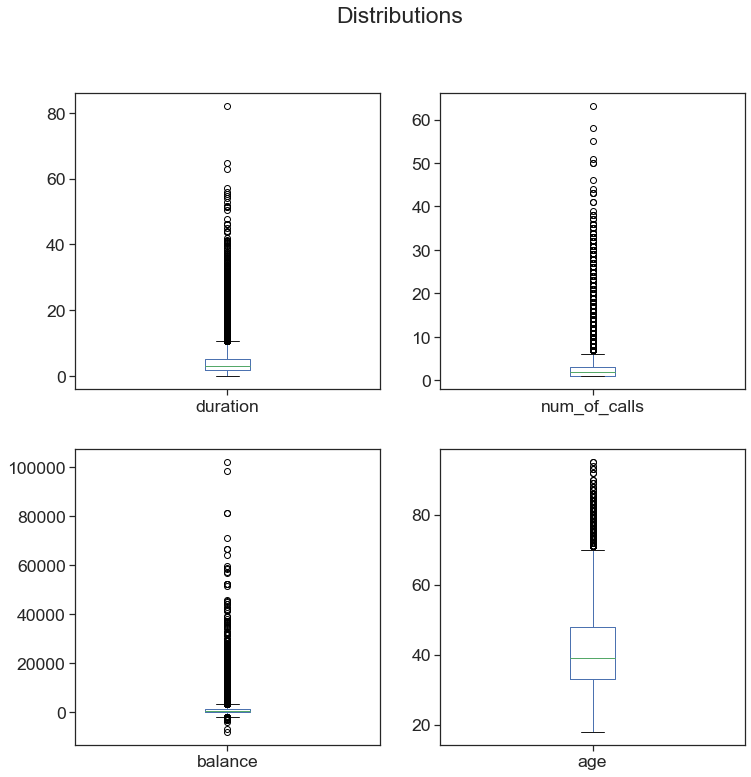

In [18]:
#viz: distribution plots
data[['duration','num_of_calls','balance','age']].plot(kind = 'box',
                                       figsize = (12,12),
                                       subplots = True, layout = (2,2),
                                       sharex = False, sharey = False,
                                       title='Distributions')
plt.show()

In [29]:
data['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [ ]:
#there is an imbalance in the class labels of our outcome, which we will address later

In [20]:
## pre-processing
data.replace(to_replace= ['no','yes'], value = [0,1], inplace=True)
preds = data.drop(['y'], axis=1)
target = data['y']

encoder = LabelEncoder()
encoder = encoder.fit(target)
target = encoder.transform(target)

preds = pd.get_dummies(preds, prefix_sep='_', drop_first=True) #convenient pandas method for categorical encoding vars with many levels
preds.head()

,age,default,balance,housing,loan,day,duration,num_of_calls,pdays,job_blue-collar,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,42,0,-249,1,0,14,2.48,3,-1,0,...,0,0,0,1,0,0,0,0,0,0
1,30,0,297,1,0,25,3.63,1,-1,1,...,0,0,0,1,0,0,0,0,0,0
2,29,0,2,1,0,6,5.65,1,362,0,...,0,0,0,0,0,0,1,0,0,0
3,57,0,5431,1,1,6,6.38,1,-1,1,...,0,0,0,0,0,0,1,0,0,0
4,56,0,145,0,0,4,3.73,1,-1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
#scaler = StandardScaler()
#scaled_preds = scaler.fit_transform(preds,)
#preds_df = pd.DataFrame(scaled_preds, index=data.index, columns=preds.columns)

In [21]:
#preds_df.head()

In [22]:
#train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(preds, target, test_size=0.20, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(36168, 36) (36168,)
(9043, 36) (9043,)


# Logistic Regression

In [23]:
## Specify-Compile
model_log = LogisticRegression(dual = False, penalty = 'l2')

params = {
        'max_iter': [100,110,120,130,140,150],
        'C' : [0.5, 1, 1.5, 2, 2.5, 3]
         }

randomSearch = RandomizedSearchCV(model_log,param_distributions=params,
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_iter=20,
                                   n_jobs=-1,
                                   refit = True,
                                   verbose = 2,
                                   random_state = 1205)

In [24]:
## fit
start_time = timer(None) # timing starts
randomSearch.fit(X_train, y_train)
timer(start_time) # timing ends

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.5s finished



 Time taken: 0 hours 0 minutes and 16.32 seconds.


In [25]:
print(randomSearch.best_params_) #model with best params found via random search

{'max_iter': 150, 'C': 2.5}


In [27]:
Score_log = randomSearch.score(X_train, y_train) #training error
print("Score: %.2f%%" % (Score_log * 100.0))

Score: 82.98%


In [28]:
# pickle model with best params
joblib_file = "joblib_log_Model.pkl" 
best_model = randomSearch.best_estimator_
joblib.dump(best_model, joblib_file)

['joblib_log_Model.pkl']

In [34]:
# Addressing class imbalance via SMOTE (over-sampling of minority class)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

model_log2 = LogisticRegression(dual = False, penalty = 'l2', max_iter=150, C=2.5)
model_log2.fit(X_train_res, y_train_res)

LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
Score_logSMOTE = model_log2.score(X_train, y_train)
print("Score: %.2f%%" % (Score_logSMOTE * 100.0))

Score: 85.09%


In [36]:
#%% pickle model
joblib_file = "joblib_logSMOTE_Model.pkl"  
joblib.dump(model_log2, joblib_file)

['joblib_logSMOTE_Model.pkl']

# Random Forest

In [41]:
# Specify-Compile
model_RF = RandomForestClassifier(n_estimators=1000,criterion='entropy', class_weight='balanced') #using the balanced class_weight parameter to compensate for class imbalance

params = {         
            'min_samples_split': [4,6,8,10],
            'max_depth': [10,12,14,16,18]
         }  

randomSearch = RandomizedSearchCV(model_RF,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_jobs=-1,
                                   refit = True,
                                   return_train_score=True,
                                   verbose = 2,
                                   random_state = 2049)

In [42]:
#fit
start_time = timer(None) 
randomSearch.fit(X_train, y_train)
timer(start_time) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished



 Time taken: 0 hours 5 minutes and 58.11 seconds.


In [43]:
print(randomSearch.best_params_)

{'min_samples_split': 10, 'max_depth': 18}


In [44]:
Score_RF = randomSearch.score(X_train, y_train)
print("Score: %.2f%%" % (Score_RF * 100.0))

Score: 98.74%


In [ ]:
#way overfit, need to revisit

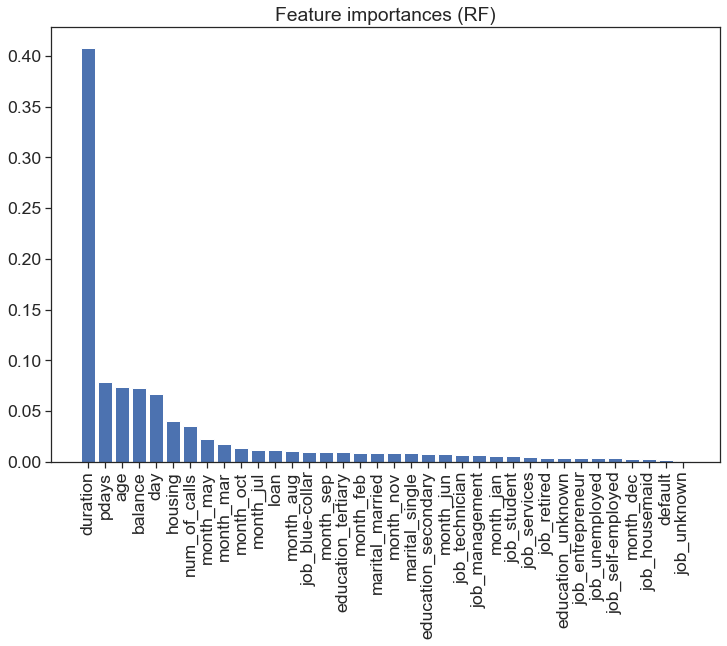

In [45]:
#feature importance
importances = model_RF.best_estimator_.feature_importances_
headers = ["var", "score"]
values = sorted(zip(X_train.columns, importances), key=lambda x: x[1] * -1)
imp = pd.DataFrame(values, columns = headers)

#plot
x_pos = np.arange(0, len(imp))
plt.figure(figsize=(12,8))
plt.bar(x_pos, imp['score'])
plt.xticks(x_pos, imp['var'])
plt.xticks(rotation=90)
plt.title('Feature importances (RF)')

plt.show()

In [46]:
#%% pickle model
joblib_file = "joblib_RF_Model.pkl"
best_model = randomSearch.best_estimator_
joblib.dump(best_model, joblib_file)

['joblib_RF_Model.pkl']

# XGBoost

In [48]:
#to derive scale_pos_weight
neg = np.array(np.unique(y_train, return_counts=True))[1,0]
pos = np.array(np.unique(y_train, return_counts=True))[1,1]
sp_weight = neg/pos

model_XGB = xgb.XGBClassifier(objective='binary:logistic', tree_method = 'hist',scale_pos_weight=sp_weight, n_estimators=1000)
params = {
            'learning_rate': [.01,.03,.05],
            'max_depth': [5,6,7,8],
            'gamma': [0,1,2],
            'reg_alpha': [0,.1,.2,.3],
            'reg_lambda': [0,1,2],    
            'subsample': [.5,.75]
         }

randomSearch = RandomizedSearchCV(model_XGB,param_distributions=params, 
                                   scoring = 'roc_auc',
                                   cv = 3,
                                   n_iter=20,
                                   n_jobs=-1,
                                   refit = True,
                                   verbose = 2,
                                   random_state = 2054, 
                                   return_train_score=True)

In [49]:
#%% fit
start_time = timer(None) 
randomSearch.fit(X_train, y_train)
timer(start_time) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.0min finished



 Time taken: 0 hours 7 minutes and 24.17 seconds.


In [50]:
print(randomSearch.best_params_)

{'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1}


In [51]:
Score_XGB = randomSearch.score(X_train, y_train)
print("Score: %.2f%%" % (Score_XGB * 100.0))

Score: 97.08%


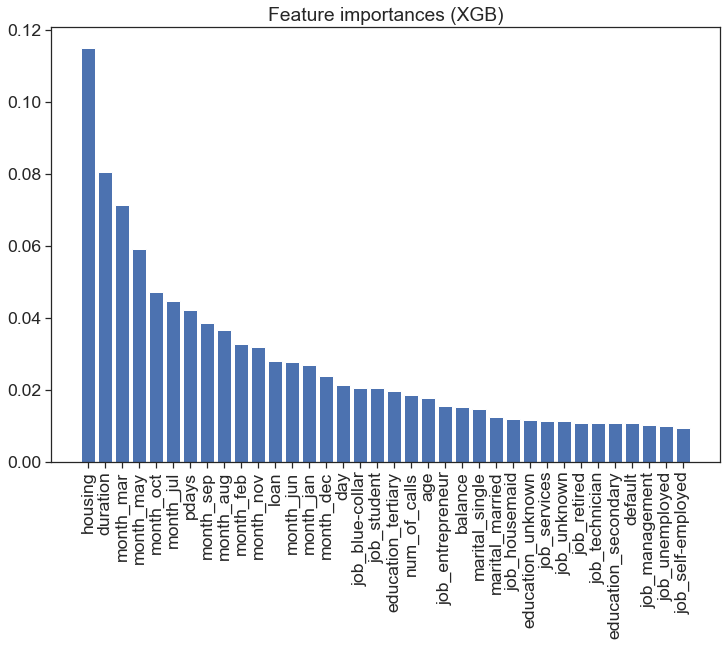

In [52]:
#feature importance
importances = randomSearch.best_estimator_.feature_importances_
headers = ["var", "score"]
values = sorted(zip(X_train.columns, importances), key=lambda x: x[1] * -1)
imp = pd.DataFrame(values, columns = headers)

#plot
x_pos = np.arange(0, len(imp))
plt.figure(figsize=(12,8))
plt.bar(x_pos, imp['score'])
plt.xticks(x_pos, imp['var'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

In [57]:
#%% pickle model
joblib_file = "joblib_XGB_Model.pkl" 
best_model = randomSearch.best_estimator_
joblib.dump(best_model, joblib_file)

['joblib_XGB_Model.pkl']

# Evaluating models

In [58]:
Model_LogR = joblib.load('joblib_log_Model.pkl')
Model_LogRSMOTE = joblib.load('joblib_logSMOTE_Model.pkl')
Model_RF = joblib.load('joblib_RF_Model.pkl')
Model_XG = joblib.load('joblib_XGB_Model.pkl')

In [59]:
#%% evaluate
for model in (Model_LogR, Model_LogRSMOTE, Model_RF, Model_XG):
    y_pred = model.predict(X_test)
    name =[x for x in globals() if globals()[x] is model][0]
    print('--')
    print("%s" % name)
    print('accuracy:', '%.2f' % accuracy_score(y_test, y_pred))
    print('precision:', '%.2f' % precision_score(y_test,y_pred))
    print('recall:', '%.2f' % recall_score(y_test,y_pred))
    print('F1', '%.2f' % f1_score(y_test,y_pred))
    print('ROC AUC:','%.2f' % roc_auc_score(y_test, y_pred))

--
Model_LogR
accuracy: 0.89
precision: 0.57
recall: 0.22
F1 0.32
ROC AUC: 0.60
--
Model_LogRSMOTE
accuracy: 0.85
precision: 0.40
recall: 0.62
F1 0.49
ROC AUC: 0.75
--
Model_RF
accuracy: 0.89
precision: 0.50
recall: 0.78
F1 0.61
ROC AUC: 0.84
--
Model_XG
accuracy: 0.86
precision: 0.45
recall: 0.89
F1 0.59
ROC AUC: 0.87


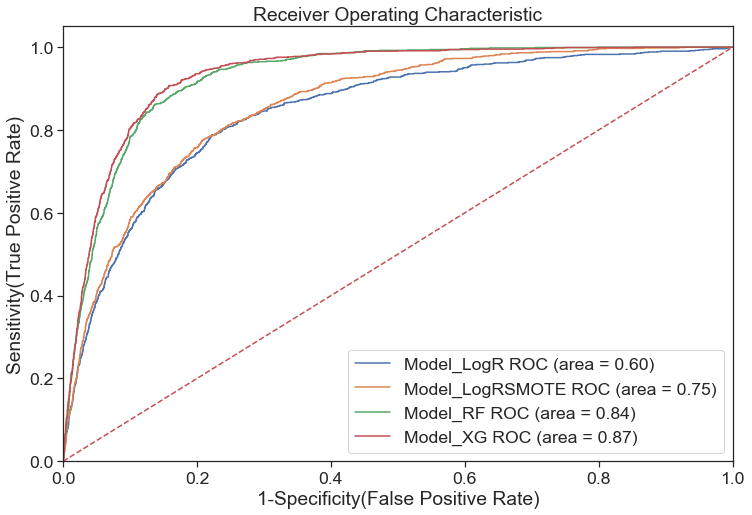

In [62]:
plt.figure(figsize=(12,8))

for model in (Model_LogR, Model_LogRSMOTE, Model_RF, Model_XG):
    y_pred = model.predict(X_test) # predict the test data
    name =[x for x in globals() if globals()[x] is model][0]
# Compute False postive rate, True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve 
    auc = roc_auc_score(y_test,model.predict(X_test))
# Plot values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
# Customize plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 